In [1]:
import xgboost as xgb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, mean_squared_error
from pandas.plotting import scatter_matrix
import pickle



In [24]:
nlp_df = pd.read_csv('../data/df_with_nlp.csv', index_col=0)
X = nlp_df
# X = X[['culture-values-stars', 'career-opportunities-stars',
#                        'comp-benefit-stars', 'senior-management-stars', 'helpful-count',
#                        'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter', 'timesteps', 'incomplete_review', 'pros_len', 'cons_len']]
y = pd.read_csv("../data/work-balance-stars.csv", header=None, index_col=0).values

,amazon_earnings_this_quarter,career-opportunities-stars,comp-benefit-stars,cons_len,culture-values-stars,helpful-count,incomplete_review,is_current_employee,pros_len,quarter,...,word_pro_young,word_pro_younger,word_pro_your,word_pro_yr,word_pro_zero,word_pro_zeta,word_pro_zone,word_pro_zu,word_pro_équip,year
0,1.777942,5.0,4.0,-0.075973,5.0,-0.079682,0,1,-0.254434,4,...,0,0,0,0,0,0,0,0,0,2018
1,-0.556614,5.0,5.0,-0.004415,5.0,103.420647,0,1,0.855601,1,...,0,0,0,0,0,0,0,0,0,2016
2,-0.556614,3.0,4.0,0.356129,3.0,82.532292,0,1,1.804681,1,...,0,0,0,0,0,0,0,0,0,2016
3,-0.810128,5.0,5.0,1.396475,3.0,74.941875,0,1,6.189318,4,...,0,0,0,0,0,0,0,0,0,2013
4,-0.360675,1.0,5.0,3.631293,2.0,23.986057,0,0,0.195130,1,...,0,0,0,0,0,0,0,0,0,2017


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [39]:
X_train = X_train.reindex(sorted(X.columns), axis=1)
X_test = X_test.reindex(sorted(X.columns), axis=1)

In [46]:
for i in range(len(X_train.columns.values)):
    print(X_train.columns.values[i])

amazon_earnings_this_quarter
career-opportunities-stars
comp-benefit-stars
cons_len
culture-values-stars
helpful-count
incomplete_review
is_current_employee
pros_len
quarter
senior-management-stars
timesteps
word_con_00
word_con_10
word_con_100
word_con_11
word_con_12
word_con_14
word_con_15
word_con_20
word_con_24
word_con_25
word_con_30
word_con_50
word_con_60
word_con_70
word_con_75
word_con_80
word_con_abil
word_con_abl
word_con_absenc
word_con_absent
word_con_absolut
word_con_absurd
word_con_abus
word_con_abysm
word_con_accept
word_con_access
word_con_accommod
word_con_accomplish
word_con_accord
word_con_account
word_con_accur
word_con_ach
word_con_achiev
word_con_acknowledg
word_con_across
word_con_act
word_con_action
word_con_activ
word_con_actual
word_con_ad
word_con_adapt
word_con_add
word_con_addict
word_con_addit
word_con_address
word_con_adequ
word_con_adher
word_con_adjust
word_con_administr
word_con_advanc
word_con_advantag
word_con_advertis
word_con_advic
word_con_affect

word_pro_alexa
word_pro_align
word_pro_all
word_pro_allot
word_pro_allow
word_pro_almost
word_pro_alon
word_pro_along
word_pro_alot
word_pro_alreadi
word_pro_alright
word_pro_also
word_pro_although
word_pro_alway
word_pro_am
word_pro_amaz
word_pro_amazingli
word_pro_amazon
word_pro_amazonian
word_pro_ambassador
word_pro_ambianc
word_pro_ambienc
word_pro_ambigu
word_pro_ambit
word_pro_ambiti
word_pro_amen
word_pro_american
word_pro_among
word_pro_amongst
word_pro_amount
word_pro_ampl
word_pro_amzn
word_pro_an
word_pro_analysi
word_pro_analyst
word_pro_analyt
word_pro_and
word_pro_angenehm
word_pro_anim
word_pro_annual
word_pro_anoth
word_pro_answer
word_pro_anybodi
word_pro_anymor
word_pro_anyon
word_pro_anyth
word_pro_anytim
word_pro_anyway
word_pro_anywher
word_pro_apart
word_pro_app
word_pro_appli
word_pro_applic
word_pro_apprais
word_pro_appreci
word_pro_apprentissag
word_pro_approach
word_pro_approv
word_pro_arbeit
word_pro_arbeiten
word_pro_arbeitsumfeld
word_pro_architect
word_pr

word_pro_zone
word_pro_zu
word_pro_équip
year


### Random Forest

In [24]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100, 200, 500, 1000],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
rf_gridsearch.fit(X_train, y_train)
print( "best parameters:", rf_gridsearch.best_params_ )

best_rf_model = rf_gridsearch.best_estimator_


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 39.9min finished


best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 1}


In [104]:
best_params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 1}
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

C:\Users\jq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [105]:
y_pred = rf.predict(X_test)

In [106]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)
print(mse)

1.246871545469176
1.5546886509006912


### Gradient Boosted Regressor

In [41]:
xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1000, verbose=1, max_depth=3)
xgb_model.fit(X_train, y_train, verbose=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose=1)

In [42]:
y_pred = xgb_model.predict(X_test)

In [43]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)
print(mse)

0.8538093475724798
0.7289904020021437


In [12]:
for i in range(len(y_test)):
    print(y_test[i], y_pred[i])

[5.] 3.9797423
[1.] 1.7693207
[2.] 2.279996
[3.] 3.695397
[3.] 2.9150822
[5.] 3.8396327
[2.] 2.2789874
[4.] 3.5017958
[5.] 4.245605
[4.] 3.9423468
[4.] 2.3947778
[1.] 2.0634103
[4.] 3.6227703
[2.] 2.9442503
[2.] 3.4718711
[4.] 3.452802
[5.] 3.9022155
[3.] 2.8611445
[3.] 3.530453
[2.] 2.4089222
[1.] 2.6474483
[2.] 2.294413
[4.] 4.18513
[4.] 3.9214506
[5.] 3.0160527
[3.] 3.3047702
[5.] 4.1960554
[5.] 4.0006533
[3.] 2.5837927
[2.] 3.4201665
[4.] 3.771519
[1.] 2.9113626
[2.] 1.7934757
[3.] 2.1785388
[1.] 1.8225815
[5.] 4.5006146
[3.] 2.8570554
[3.] 3.76454
[3.] 3.7718654
[3.] 3.203229
[3.] 1.7157813
[3.] 3.739547
[4.] 4.0849733
[4.] 3.4501069
[2.] 2.7999525
[5.] 4.3966665
[2.] 2.2834277
[2.] 1.9575636
[3.] 3.357891
[2.] 2.67648
[3.] 3.2247956
[3.] 3.7596223
[2.] 2.377966
[5.] 4.315549
[5.] 4.823158
[1.] 3.091761
[1.] 2.0250387
[5.] 4.6554356
[3.] 2.8486888
[1.] 1.2941513
[2.] 2.4417033
[4.] 3.4632595
[5.] 3.7948718
[3.] 3.0964108
[4.] 3.8291633
[3.] 1.1995348
[4.] 3.339212
[5.] 4.454414
[1

[2.] 4.1030273
[3.] 3.2376597
[5.] 4.459019
[3.] 3.4084556
[4.] 3.6628222
[3.] 2.9031603
[2.] 2.0445228
[1.] 1.5992094
[1.] 1.6032017
[5.] 4.1623826
[3.] 2.881769
[4.] 4.154299
[3.] 3.6862705
[3.] 2.9778454
[4.] 4.1416078
[2.] 3.4176533
[5.] 4.5958543
[2.] 2.4844446
[4.] 2.3970518
[4.] 3.1670184
[3.] 3.5924516
[1.] 2.2727442
[3.] 2.682878
[3.] 3.1076188
[1.] 1.2954855
[1.] 1.7999978
[5.] 4.5612464
[4.] 3.0246592
[4.] 3.68324
[3.] 2.1008234
[2.] 2.59824
[3.] 2.989026
[1.] 1.6803963
[4.] 4.3443947
[3.] 2.9519384
[2.] 3.0893605
[3.] 3.164024
[4.] 3.5102668
[3.] 2.8569882
[1.] 1.5196906
[5.] 4.5259147
[3.] 3.2467933
[4.] 4.336012
[2.] 2.601163
[4.] 3.5201237
[4.] 3.6377664
[1.] 1.0936632
[1.] 2.2930472
[1.] 2.1183803
[3.] 2.8014812
[3.] 2.4561033
[5.] 3.843081
[4.] 2.8175857
[3.] 2.7568896
[5.] 4.6548915
[3.] 2.892739
[4.] 3.438319
[1.] 1.4493926
[3.] 3.0546675
[3.] 3.282435
[3.] 2.9092581
[5.] 3.7918663
[5.] 4.3649483
[4.] 3.4529557
[4.] 2.971244
[5.] 4.4129534
[3.] 3.4706378
[2.] 2.19382

[3.] 1.79208
[2.] 1.7156329
[2.] 2.341624
[3.] 3.3080728
[5.] 4.5648847
[5.] 3.984497
[5.] 1.487114
[3.] 2.324891
[2.] 2.828202
[1.] 1.9170669
[1.] 1.5130703
[3.] 2.99626
[3.] 2.8202672
[1.] 1.4431059
[1.] 2.1961203
[1.] 1.2446382
[1.] 1.6800642
[2.] 2.3484826
[2.] 3.0525687
[3.] 2.5432994
[3.] 2.8321793
[3.] 2.6272886
[2.] 1.6133354
[3.] 2.6323915
[4.] 3.959199
[3.] 3.7580855
[3.] 2.9760933
[3.] 3.1995327
[1.] 1.2799191
[4.] 3.2782576
[3.] 2.9370186
[4.] 3.3911445
[2.] 3.044487
[2.] 3.3657467
[1.] 2.7916856
[2.] 3.3735821
[2.] 2.2323875
[2.] 3.1722553
[4.] 3.456946
[3.] 3.353637
[1.] 1.9447278
[5.] 4.3840227
[2.] 2.29563
[2.] 1.7796445
[4.] 3.3929238
[5.] 3.62877
[3.] 4.081297
[2.] 2.610068
[5.] 4.1891484
[4.] 4.3319464
[3.] 3.191466
[4.] 3.2985404
[3.] 3.1574104
[2.] 3.571417
[5.] 4.9694967
[2.] 3.4920142
[3.] 3.0173218
[3.] 2.0121908
[3.] 2.887685
[5.] 4.7241387
[3.] 3.0594668
[3.5] 2.5768313
[3.] 2.9886646
[2.] 2.1244946
[5.] 3.9089856
[3.] 3.3905969
[4.] 2.5886378
[3.] 2.8862038
[

[1.] 1.1076989
[4.] 3.358032
[3.] 3.005932
[3.] 1.786102
[5.] 4.416059
[3.] 3.290752
[3.] 2.637103
[3.] 3.4076545
[3.] 2.9227781
[1.] 2.9809508
[3.] 4.156908
[4.] 3.3588197
[1.] 1.6125773
[4.] 3.0253096
[3.] 3.0627036
[5.] 2.2712107
[3.] 2.9541204
[5.] 4.4887714
[4.] 3.929132
[1.] 2.254902
[5.] 4.5408354
[3.] 2.9590228
[3.] 3.5657659
[1.] 2.2886324
[5.] 3.8327668
[5.] 3.5521126
[4.] 3.208462
[2.] 3.4426873
[1.] 1.0683506
[2.] 2.2218685
[4.] 4.1668196
[4.] 3.3086162
[4.] 3.1115336
[3.] 3.3642323
[3.] 3.0481727
[5.] 4.4194117
[1.] 2.060567
[4.] 3.9021442
[3.] 2.0291061
[1.] 1.3304315
[3.] 3.285481
[4.] 3.9215353
[2.] 2.1827025
[5.] 2.9632535
[5.] 4.571551
[2.] 4.1600647
[4.] 2.8745694
[5.] 4.914198
[2.] 1.9217784
[1.] 1.9334708
[5.] 4.398719
[1.] 2.17634
[4.] 3.3776896
[1.] 2.9263215
[3.] 2.6362207
[1.] 2.060247
[5.] 4.0950356
[1.] 1.0029948
[4.] 4.3960123
[2.] 3.0340648
[4.] 3.3359106
[1.] 4.1162806
[3.] 3.7388775
[3.] 2.9486246
[1.] 1.2292385
[2.] 2.1170712
[1.] 1.9322475
[4.] 3.791511

[5.] 3.6637075
[4.] 4.225696
[3.] 2.9631307
[1.] 2.4889526
[4.] 4.49246
[2.] 2.994602
[2.] 2.3771665
[4.] 3.3071537
[2.] 1.7585582
[1.] 1.6736923
[3.] 2.3748488
[2.] 2.9272146
[4.] 4.087197
[5.] 3.9164038
[5.] 4.7871737
[5.] 4.5844917
[1.] 1.5674522
[2.] 2.4001474
[3.] 2.281898
[4.] 3.0546675
[5.] 4.0885324
[2.] 1.9872105
[3.] 1.3810203
[1.] 1.8453683
[1.] 1.8093624
[3.] 3.1643414
[4.] 3.540264
[4.] 4.165343
[3.] 3.3755872
[4.] 2.9912212
[3.] 3.1560543
[5.] 4.4204874
[4.5] 3.6189308
[4.] 2.7779305
[4.] 4.192769
[5.] 2.5803902
[4.] 4.0292215
[5.] 3.5138397
[5.] 3.0824854
[2.] 3.059373
[3.] 2.579029
[2.] 1.3542227
[4.] 3.3755336
[1.] 1.3374659
[1.] 2.006669
[1.] 1.4548795
[1.] 1.3076671
[4.] 2.4940257
[1.] 1.8171427
[4.] 4.1772404
[3.] 1.784328
[2.] 2.286487
[4.] 3.159448
[4.5] 3.5631466
[1.] 1.6486015
[2.] 3.1063883
[5.] 4.806372
[3.] 3.6824408
[3.] 2.3394918
[3.] 3.6779888
[5.] 4.5051355
[1.] 1.4866788
[3.] 3.1852705
[3.] 3.247003
[3.] 4.653433
[4.] 3.70771
[3.] 3.275009
[3.] 2.9168746

[4.] 3.903428
[2.] 3.8072982
[3.] 3.5860465
[1.] 1.4065224
[5.] 4.6759915
[3.] 3.467828
[1.] 1.9199067
[5.] 4.4442654
[1.] 1.78808
[5.] 4.6364517
[1.] 1.3041098
[1.] 1.3430853
[5.] 4.3730717
[1.] 1.929791
[3.] 3.0226452
[2.] 1.8572712
[3.] 2.5996275
[3.] 3.2587404
[4.] 4.120364
[3.] 3.8885477
[3.] 3.0699215
[2.] 2.16895
[2.] 3.298714
[5.] 4.1124525
[2.] 1.9309033
[4.] 4.650869
[3.] 3.005932
[4.] 4.0385113
[2.] 2.0844007
[3.] 3.3801858
[3.] 3.2065115
[4.] 2.4409714
[4.] 3.6328814
[2.] 3.249083
[2.] 2.1378589
[3.] 3.0215037
[5.] 3.6384642
[1.] 2.0795722
[4.] 2.2440937
[5.] 3.5634155
[1.] 2.8980725
[3.] 3.2288432
[3.] 3.1409588
[3.] 4.04844
[4.] 4.106887
[5.] 3.84714
[4.] 4.077393
[1.] 2.7135904
[3.] 3.1254797
[5.] 2.1241612
[3.] 2.161199
[3.] 2.980524
[5.] 3.7625477
[4.] 3.890819
[4.] 3.720194
[5.] 4.7216973
[1.] 1.5290657
[3.] 2.4624035
[3.] 3.1726277
[5.] 4.6983147
[3.] 3.024095
[4.] 3.3459952
[4.] 4.5465965
[1.] 1.2375295
[5.] 3.173832
[4.] 4.051914
[2.] 1.8326389
[2.] 4.370349
[4.] 3

[2.] 2.142003
[5.] 4.6385756
[2.] 3.3440287
[3.] 2.9834878
[2.] 2.7342198
[5.] 3.270106
[4.] 3.2814357
[1.] 1.4320709
[1.] 2.112104
[5.] 2.9272175
[3.] 2.9253476
[2.] 3.0017242
[3.] 3.4426653
[4.] 3.7007
[1.] 1.5365703
[3.] 3.2670586
[3.] 3.1112485
[2.] 1.5768304
[1.] 1.2496974
[4.] 3.3452406
[1.] 1.6547947
[2.] 3.189963
[3.] 3.4883082
[2.] 2.5562632
[5.] 3.8619351
[3.] 4.321499
[4.] 2.5086875
[3.] 3.2102005
[3.] 2.846849
[2.5] 2.1046765
[5.] 4.6626625
[3.5] 3.0066135
[4.] 2.8657942
[4.] 3.4723601
[1.] 2.5903928
[1.] 1.7052181
[5.] 2.819634
[4.] 3.0990863
[3.] 3.0791852
[4.] 3.1315913
[3.] 2.8685713
[4.] 3.211008
[2.] 2.0686793
[3.] 1.9100263
[5.] 3.72538
[5.] 4.1188
[4.] 3.7282746
[3.] 3.3822668
[3.] 2.5777254
[3.] 2.8422441
[5.] 3.2818558
[5.] 4.522076
[2.] 3.5284162
[3.] 3.3385723
[3.] 2.8602633
[3.] 3.1371598
[3.] 2.3615434
[4.] 3.063738
[3.] 3.0112126
[3.] 3.0190256
[4.] 3.361156
[5.] 2.968095
[4.] 3.4997137
[1.] 1.8200368
[3.] 3.057602
[3.] 3.362147
[3.] 2.397432
[2.] 1.6396502
[

[1.] 1.6587201
[1.] 1.9802582
[3.] 3.174029
[3.] 3.184172
[1.] 1.812386
[3.] 3.4195306
[3.] 3.0168126
[3.] 2.8916533
[3.] 2.518299
[5.] 3.991142
[4.] 2.6861517
[3.] 2.9094043
[3.] 2.973994
[3.] 3.0366821
[3.] 3.3504763
[3.] 2.9000337
[1.] 1.2893139
[2.] 2.5495603
[3.] 3.7256594
[5.] 4.427169
[1.] 1.6123242
[5.] 3.1608555
[4.] 3.771327
[4.] 3.2779322
[3.] 2.9405577
[3.] 3.3708956
[3.] 2.8407855
[1.] 1.4516366
[3.] 2.789134
[3.] 2.3121495
[3.] 3.0784674
[4.] 2.581252
[1.] 0.7992598
[3.] 2.8955646
[4.5] 3.7124548
[1.] 1.3088522
[3.] 3.1231985
[4.] 3.2373717
[3.] 2.409491
[1.] 1.4481832
[1.] 2.429659
[3.] 3.1241028
[3.] 2.7413769
[3.] 3.0480154
[2.] 2.1157823
[4.] 2.8907135
[1.] 1.3200792
[3.] 2.8125024
[5.] 2.6485498
[2.] 1.9420222
[2.] 2.7948165
[3.] 4.341769
[2.] 3.5162776
[4.] 3.3800771
[4.] 3.2974417
[3.] 2.5924933
[4.] 4.0134206
[1.] 2.3043237
[4.] 2.6341922
[4.] 4.05044
[4.] 3.7487411
[5.] 1.8452947
[1.] 1.5201906
[2.] 2.3202057
[2.] 3.1919577
[4.] 2.4208946
[2.] 3.6688035
[5.] 4.34

In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)
print(mse)

0.8723116190562487
0.7609275607405339


In [44]:
with open('models/gradient_boosting_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(xgb_model, f)

In [6]:
param_grid = {'max_depth': [3],
              'learning_rate': [0.01],
              'n_estimators': [100, 200, 500, 1000],
              'subsample': [0.5]
              }

gbr_gridsearch = GridSearchCV(xgb.XGBRegressor(),
                             param_grid,
                             n_jobs=-1,
                             verbose=1,
                             scoring='neg_mean_squared_error',
                             cv=3)
gbr_gridsearch.fit(X_train, y_train)
print( "best parameters:", gbr_gridsearch.best_params_ )

best_gbr_model = gbr_gridsearch.best_estimator_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 22.3min finished


best parameters: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [32]:
best_y_preds = best_gbr_model.predict(X_test)

In [23]:
for i in range(len(y_test)):
    print(y_test[i], best_y_preds[i])

NameError: name 'best_y_preds' is not defined

In [11]:
mse = mean_squared_error(y_test, best_y_preds)
rmse = mse ** 0.5
print(mse)
print(rmse)

1.8738464762673295
1.368885121647295


In [33]:
with open('models/best_gradient_boosting_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(best_gbr_model, f)

In [73]:
y_pred = gbr.predict(X_test)

In [75]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(mse)
print(rmse)

0.8921436054582954
0.9445335385566229


### RNN

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint

In [16]:
timesteps=1

In [15]:
X_train = X_train[['culture-values-stars', 'career-opportunities-stars', 'comp-benefit-stars', 'senior-management-stars', 
                   'helpful-count', 'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter','timesteps']]
X_test = X_test[['culture-values-stars', 'career-opportunities-stars', 'comp-benefit-stars', 'senior-management-stars', 
                   'helpful-count', 'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter','timesteps']]

In [17]:
X_train = X_train.values.reshape(X_train.values.shape[0], timesteps, X_train.values.shape[1])
X_test = X_test.values.reshape(X_test.values.shape[0], timesteps, X_test.values.shape[1])

In [11]:
neurons=50
model = Sequential()
model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=5, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

IndexError: tuple index out of range

In [16]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(64, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dropout(0.2))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 42,305
Trainable params: 42,305
Non-trainable params: 0
_________________________________________________________________


In [17]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [18]:
NN_model.fit(X_train, y_train, epochs=5, batch_size=32, 
             validation_data=(X_test, y_test), verbose=2, shuffle=False, callbacks=callbacks_list)

Train on 21142 samples, validate on 5286 samples
Epoch 1/5


KeyboardInterrupt: 

In [22]:
y_pred_rnn = NN_model.predict(X_test)

In [23]:
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = mse_rnn ** 0.5
print(mse_rnn)
print(rmse_rnn)

0.9346258432920367
0.9667604891037059


In [24]:
for i in range(len(y_test)):
    print(y_test[i], y_pred_rnn[i])

[5.] [4.1761656]
[1.] [1.8084989]
[2.] [2.0011933]
[3.] [3.6878588]
[3.] [2.3888905]
[5.] [3.869947]
[2.] [2.79706]
[4.] [2.9465976]
[5.] [4.0935297]
[4.] [3.906281]
[4.] [2.121921]
[1.] [2.2541678]
[4.] [2.752099]
[2.] [2.4887455]
[2.] [3.2149134]
[4.] [3.4061322]
[5.] [3.4452055]
[3.] [2.605856]
[3.] [3.566624]
[2.] [2.5113738]
[1.] [2.2819676]
[2.] [2.0951316]
[4.] [4.0068073]
[4.] [3.5375497]
[5.] [2.7366235]
[3.] [2.9121008]
[5.] [3.9962378]
[5.] [3.8482556]
[3.] [2.220698]
[2.] [3.2053852]
[4.] [3.463785]
[1.] [2.8283448]
[2.] [1.516482]
[3.] [2.712854]
[1.] [1.4832016]
[5.] [4.00848]
[3.] [2.6379664]
[3.] [3.929514]
[3.] [3.8243966]
[3.] [2.9127626]
[3.] [1.1986066]
[3.] [3.3311567]
[4.] [3.447555]
[4.] [2.755255]
[2.] [2.4578624]
[5.] [3.9506316]
[2.] [1.9650505]
[2.] [1.6915774]
[3.] [3.0746908]
[2.] [2.473094]
[3.] [3.9081087]
[3.] [3.6841202]
[2.] [2.3704176]
[5.] [3.9641607]
[5.] [4.1103344]
[1.] [3.1769378]
[1.] [1.7043301]
[5.] [4.147648]
[3.] [2.4231157]
[1.] [1.4103967]

[3.] [2.4695961]
[1.] [1.4152666]
[1.] [1.4456857]
[5.] [3.0351188]
[4.] [3.0227823]
[5.] [3.2447393]
[1.] [2.1262972]
[3.] [2.346066]
[3.] [3.1549473]
[1.] [1.3132737]
[1.] [1.4527909]
[2.] [3.9235737]
[1.] [2.395559]
[2.] [3.009529]
[3.] [2.6193504]
[2.] [3.1357975]
[4.] [3.4581268]
[5.] [3.9657676]
[3.] [3.5969915]
[3.] [2.717136]
[4.] [4.0068073]
[1.] [2.8166924]
[4.] [3.4453819]
[2.] [1.3930093]
[3.] [4.098452]
[5.] [3.2011302]
[3.] [1.5785695]
[2.] [3.9506023]
[4.] [3.1120095]
[4.] [3.3635454]
[1.] [2.5417457]
[4.] [3.6752338]
[5.] [3.7531395]
[2.] [2.3492208]
[3.] [2.7423334]
[4.] [2.7657022]
[2.] [3.6718578]
[5.] [3.9579258]
[3.] [3.8364456]
[3.] [2.6905766]
[4.] [2.8052742]
[3.] [2.5572462]
[5.] [3.6110272]
[5.] [4.1921062]
[3.] [2.7022295]
[3.] [2.3881567]
[1.] [2.340318]
[3.] [2.2707756]
[4.] [3.0542223]
[3.5] [2.2729394]
[1.] [1.9919504]
[5.] [3.6906993]
[3.] [2.557191]
[4.] [3.4295597]
[5.] [3.3495588]
[3.] [2.760971]
[4.] [3.5222526]
[5.] [1.5665004]
[5.] [4.047924]
[4.] 

[1.] [2.2622764]
[3.] [2.3938355]
[2.] [3.2616942]
[4.] [2.5411217]
[2.] [2.4154277]
[3.] [1.832369]
[3.] [3.0732088]
[3.] [3.1668487]
[5.] [3.5720682]
[3.] [3.1618516]
[2.] [3.1112533]
[3.] [3.875776]
[4.] [3.301107]
[1.] [2.6321084]
[5.] [3.5618207]
[4.] [1.5534732]
[3.] [3.556255]
[1.] [1.2523057]
[3.] [3.6341472]
[1.] [1.4805745]
[4.] [3.6990485]
[4.5] [2.2660034]
[3.] [2.5744622]
[3.] [2.4413319]
[5.] [3.0948572]
[3.] [2.4603271]
[3.] [2.6479592]
[4.] [3.3375099]
[3.] [1.80093]
[2.] [1.4280525]
[2.] [1.628427]
[3.] [3.5509133]
[5.] [4.1921062]
[5.] [3.6545265]
[5.] [1.2811352]
[3.] [2.1824086]
[2.] [2.5580487]
[1.] [1.5355135]
[1.] [1.4043592]
[3.] [2.5596125]
[3.] [3.4348018]
[1.] [1.2945541]
[1.] [2.6168401]
[1.] [1.2553966]
[1.] [1.6361902]
[2.] [1.8579448]
[2.] [2.4859211]
[3.] [2.5168495]
[3.] [2.6632218]
[3.] [3.177736]
[2.] [1.2586812]
[3.] [2.4365997]
[4.] [3.8621407]
[3.] [3.3034925]
[3.] [2.6030252]
[3.] [2.5017262]
[1.] [1.3507036]
[4.] [3.0351188]
[3.] [2.557191]
[4.] 

[1.] [1.6009159]
[1.] [1.5106536]
[3.] [2.3724072]
[5.] [3.816186]
[4.] [3.774988]
[1.] [1.7103893]
[3.] [2.2903924]
[5.] [3.3975782]
[3.] [1.7552975]
[1.] [2.3735688]
[5.] [4.147648]
[2.] [2.6326587]
[5.] [3.8947892]
[3.] [2.4359417]
[4.] [3.583796]
[4.] [3.8074627]
[3.] [2.5449147]
[4.] [2.9172628]
[3.] [2.4840963]
[4.] [3.2234864]
[4.] [3.4533322]
[5.] [4.180867]
[5.] [4.0775375]
[5.] [3.9217365]
[2.] [2.506994]
[4.] [4.180867]
[3.] [1.5814395]
[4.] [3.424028]
[3.] [2.79706]
[1.] [2.2046058]
[3.] [3.2494485]
[5.] [2.143631]
[1.] [1.2677857]
[5.] [4.0783873]
[3.] [2.394045]
[5.] [3.8699005]
[4.] [1.6352662]
[3.] [2.884698]
[2.] [2.3537264]
[4.] [2.7159846]
[5.] [3.9898732]
[5.] [2.6153367]
[3.] [2.5008135]
[5.] [4.180867]
[3.] [2.535679]
[2.] [3.5180383]
[4.] [2.8359227]
[4.] [3.1646278]
[3.] [2.4840963]
[4.] [3.3635454]
[4.] [4.0068073]
[1.] [1.2649802]
[1.] [1.8075501]
[5.] [2.8935654]
[1.] [1.2142321]
[3.] [2.4840965]
[4.] [3.9962378]
[1.] [1.8350053]
[4.] [3.7010543]
[3.] [3.3652

[1.] [2.582086]
[2.] [1.8047987]
[4.] [4.090114]
[1.] [1.6548905]
[3.] [2.6905766]
[3.] [3.5280924]
[1.] [1.2156402]
[5.] [3.9028347]
[5.] [3.4626162]
[1.] [1.9090949]
[2.] [3.0218701]
[5.] [4.0846224]
[4.] [3.9049532]
[2.] [3.7292242]
[4.] [3.4596527]
[3.] [2.6905766]
[3.] [2.3738375]
[3.] [3.5707283]
[4.] [3.9399729]
[3.] [4.0846224]
[3.] [3.2645354]
[3.] [3.8195114]
[1.] [2.389894]
[3.] [2.3454494]
[4.] [3.5251226]
[2.] [1.9436793]
[3.] [3.2559927]
[5.] [4.047924]
[2.] [3.384416]
[3.] [1.3485447]
[4.] [3.056467]
[5.] [3.8301406]
[3.] [2.5134997]
[4.] [2.925209]
[3.] [3.550378]
[4.] [2.695281]
[5.] [4.180867]
[5.] [3.3293166]
[3.] [2.7022295]
[3.] [2.7747593]
[1.] [1.3469983]
[3.] [2.2924454]
[3.] [3.487986]
[2.] [1.4153727]
[5.] [2.1774306]
[4.] [3.3665476]
[1.] [1.5327523]
[2.] [2.9839778]
[4.] [3.5664644]
[3.] [2.7022295]
[2.] [2.518637]
[5.] [2.341807]
[3.] [2.6087418]
[4.] [1.5963196]
[5.] [4.013043]
[4.] [3.297246]
[2.] [2.5690856]
[3.] [2.4717457]
[3.] [3.4351244]
[3.] [3.7218

[1.] [1.548851]
[2.] [3.8084037]
[5.] [3.7787614]
[2.] [2.5116997]
[2.] [2.1967127]
[5.] [4.195257]
[4.] [2.7501493]
[2.] [1.3350375]
[3.] [3.484006]
[4.] [4.047924]
[3.] [3.5259087]
[5.] [4.0783873]
[4.] [2.497145]
[1.] [1.354826]
[1.] [2.1287467]
[1.] [2.5775123]
[1.] [1.4946982]
[2.] [2.448368]
[4.] [3.3322434]
[3.] [2.6905766]
[3.] [2.4840963]
[4.] [3.8243966]
[3.] [2.9749224]
[3.] [2.5809603]
[1.] [2.423387]
[3.] [2.8440757]
[4.] [2.454697]
[4.] [3.109428]
[1.] [2.3062391]
[5.] [2.9395714]
[2.] [1.8173219]
[4.] [3.1381638]
[1.] [2.8562317]
[3.] [2.7263055]
[3.] [3.4637852]
[2.] [3.6587906]
[3.] [2.9378667]
[4.] [2.9420123]
[1.] [2.137479]
[4.5] [2.5718637]
[4.] [2.4335737]
[4.] [3.8248026]
[3.] [4.093936]
[3.] [2.072914]
[4.] [4.1103344]
[3.] [3.1588686]
[1.] [1.4111139]
[3.] [2.5534315]
[4.] [4.056781]
[3.] [3.3975782]
[1.] [1.2986476]
[2.] [2.5411217]
[5.] [4.031496]
[4.] [3.215529]
[4.] [3.1646278]
[2.] [3.1357975]
[3.] [2.3285017]
[1.] [2.1871514]
[5.] [4.1952577]
[1.] [1.5688

[1.] [3.6708393]
[3.] [3.157726]
[1.] [2.508562]
[4.] [4.195257]
[2.] [2.432961]
[4.] [3.2981796]
[3.] [2.608742]
[3.] [2.2008781]
[5.] [3.944367]
[4.] [3.361277]
[5.] [4.0271864]
[1.] [3.244263]
[1.] [1.2301612]
[4.] [3.8924422]
[4.] [3.0024748]
[1.] [1.7257802]
[3.] [3.169903]
[1.] [2.7409096]
[1.] [1.4241499]
[2.] [2.4583712]
[2.] [1.2673668]
[3.] [2.5809603]
[2.] [3.1869335]
[5.] [4.1793165]
[2.] [2.7117863]
[4.] [3.1641533]
[3.] [3.1373014]
[3.] [2.2284153]
[1.] [1.346516]
[2.] [3.320427]
[2.] [1.650745]
[3.] [2.6564765]
[1.] [1.791385]
[2.] [2.0087748]
[3.] [2.3737533]
[4.] [3.2355132]
[3.] [3.774988]
[3.] [2.4365997]
[5.] [4.0731792]
[1.] [1.484321]
[1.] [2.7518888]
[2.] [1.7828752]
[2.] [3.0945415]
[4.] [2.2171705]
[1.] [1.3392445]
[3.] [2.4365997]
[1.] [1.2109323]
[3.] [2.3910036]
[1.] [1.2929133]
[2.] [2.937097]
[5.] [4.147648]
[2.] [3.5552635]
[3.] [2.4859211]
[2.] [2.5741673]
[5.] [3.1415572]
[4.] [3.1390767]
[1.] [1.5534464]
[1.] [2.069875]
[5.] [2.550146]
[3.] [2.0080323]

[3.] [1.9537917]
[3.] [3.4575112]
[1.] [1.7386645]
[4.] [3.7208693]
[1.] [3.4734824]
[3.] [3.6018827]
[5.] [3.878515]
[1.] [2.2495518]
[4.] [2.2273686]
[2.] [3.1982067]
[1.] [1.46252]
[2.] [3.6420555]
[3.] [1.4829243]
[2.] [2.0171595]
[3.] [3.9266114]
[3.] [3.878515]
[3.] [2.0546246]
[2.] [2.7246153]
[2.] [2.6901982]
[4.] [3.1980696]
[4.] [3.2616942]
[3.] [2.4578624]
[1.] [1.5406233]
[3.] [2.6193504]
[4.] [3.1216273]
[4.] [4.0068073]
[3.] [2.4335737]
[2.] [1.508984]
[3.] [2.4840963]
[3.] [2.6905766]
[2.] [2.2259002]
[3.] [3.0240717]
[4.] [3.5533032]
[4.] [3.809254]
[4.] [3.5251226]
[4.] [3.9279237]
[1.] [1.3018731]
[1.] [2.003161]
[5.] [3.2695193]
[3.] [2.604031]
[4.] [4.1103344]
[2.] [1.6874747]
[3.] [3.301107]
[3.] [2.256686]
[5.] [3.5391397]
[1.] [2.5637612]
[1.] [2.0720823]
[3.5] [2.4850438]
[3.] [2.618898]
[3.] [2.3764]
[1.] [1.3509091]
[5.] [4.0190287]
[2.] [2.542573]
[3.] [2.449524]
[5.] [3.7787614]
[2.5] [2.240902]
[3.5] [2.7903645]
[1.] [2.1404183]
[5.] [2.5771422]
[2.] [1.691

In [56]:
with open('models/rnn_model.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(model, f)

In [53]:
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = mse_rnn ** 0.5
print(mse_rnn)
print(rmse_rnn)

1.6099188849161883
1.2688257898215138


### Later

In [ ]:
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:
_ = scatter_matrix(amazon_df, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [ ]:


fig, ax = plt.subplots(figsize=(14, 3))

plot_univariate_smooth(
    ax, 
    non_zero_bal_df["limit"].values.reshape(-1, 1),
    non_zero_bal_df['balance'],
    bootstrap=100)

ax.set_title("Univariate Effect of Credit Limit on Non-zero Bank Balance")
ax.set_ylabel("Non-zero Balance")
ax.set_xlabel("Limit")

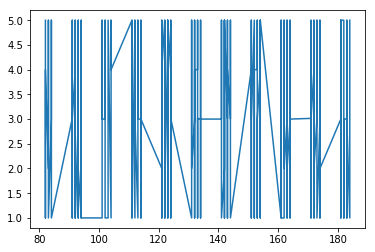

In [6]:
plt.plot(X['timesteps'], y)

In [ ]:
limit_fit = Pipeline([
    ('limit', ColumnSelector(name='limit')),
    ('limit_spline', LinearSpline(knots=[2500, 6000, 7000]))
])